#TASK 1

1.   PyTorch provides two data primitives: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset` that allow you to use pre-loaded datasets as well as your own data. Use the `torchvision.datasets` to import preloaded Dataset [`CIFAR`](https://pytorch.org/vision/stable/datasets.html#cifar) to train and then finetune the ResNet18 model.

In [ ]:
#Loading in Resnet18 pre-trained Model
import torchvision.models as models
model = models.resnet18(pretrained = True)
model
#You can use ```dir(models)``` to see various models available for Transfer Learning

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
#Freeze the model weights
for param in model.parameters():
    param.requires_grad = False

In [ ]:
#Add the fully connected layer
import torch.nn as nn
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)         
model = model.to('cuda') 
#Here replace num_classes with number of classes you are classifying 

In [ ]:
#Check model summary once to ensure the changes you made
from torchsummary import summary
summary(model, input_size=(3, 299, 299), batch_size=8, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [8, 64, 150, 150]           9,408
       BatchNorm2d-2          [8, 64, 150, 150]             128
              ReLU-3          [8, 64, 150, 150]               0
         MaxPool2d-4            [8, 64, 75, 75]               0
            Conv2d-5            [8, 64, 75, 75]          36,864
       BatchNorm2d-6            [8, 64, 75, 75]             128
              ReLU-7            [8, 64, 75, 75]               0
            Conv2d-8            [8, 64, 75, 75]          36,864
       BatchNorm2d-9            [8, 64, 75, 75]             128
             ReLU-10            [8, 64, 75, 75]               0
       BasicBlock-11            [8, 64, 75, 75]               0
           Conv2d-12            [8, 64, 75, 75]          36,864
      BatchNorm2d-13            [8, 64, 75, 75]             128
             ReLU-14            [8, 64,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
#Define your transformations to be applied on the images here
from torchvision import transforms
train_transforms = transforms.Compose(
 [
  transforms.RandomApply(transforms =[transforms.Pad(8, padding_mode='symmetric'),
                                        transforms.RandomAffine(degrees = 16, translate = (0.05,0.05), scale = (0.64,0.9), fill=(124,252,0))], p=0.3), 
    
  transforms.RandomResizedCrop(224),  
  transforms.RandomHorizontalFlip(),  
  transforms.RandomPosterize(2, p=0.2),  #posterizes the image 


  transforms.ColorJitter(brightness=0.7, contrast=(0.1,1.5), saturation=0.4, hue=0.25),  #Jitters the given parameters

  transforms.RandomGrayscale(p=0.1,),  #Randomly converts image to grayscale, note by default if input image has 3 channels,
                                        #output image also has 3 channels
  
  transforms.ToTensor(),              
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  #Default ImageNet values

 ]

)
val_transforms = transforms.Compose([           
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [ ]:
#Import the CIFAR apply the transformations you created above
#You can access the link given in question statement to check syntax for importing fakedata dataset
#Create DataLoaders for you train and val Datasets
from torchvision.datasets import CIFAR10
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
train_set = CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms)
train_loader = DataLoader(train_set, batch_size=32,
                                          shuffle=True)
val_set = CIFAR10(root='./data', train=False,
                                       download=True, transform=val_transforms)
val_loader = DataLoader(val_set, batch_size=32,
                                         shuffle=False)
#Remember to split the dataset into train_dataset and val_dataset

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
'''Define your train function here
you may exclude the timer and scheduler'''
import numpy as np
import torch


def train(model,
          criterion,
          optimizer,
          scheduler,          
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=2):
  
  # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    

     # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')
    
    
    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        scheduler.step(valid_loss)
        model.train()
        
        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Get model outputs and calculate loss
            # Special case for inception because in training it has an auxiliary output. In train
            # mode we calculate the loss by summing the final output and the auxiliary output
            # but in testing we only consider the final output.
             # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
            output= model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        
                        return model

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    return model

In [ ]:
'''define the criterion,optimizer and scheduler(if used) parameters here'''
from torch import optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=2)

In [ ]:
'''run the model''' 
model = train(
    model,
    criterion,
    optimizer,
    scheduler,
    train_loader,
    val_loader,
    save_file_name="best.pth",
    max_epochs_stop=5,
    n_epochs=30,
    print_every=2
  )

Model has been trained for: 0 epochs.


Epoch: 1 	Training Loss: 1.7618 	Validation Loss: 0.9968
		Training Accuracy: 38.26%	 Validation Accuracy: 68.23%

Epoch: 3 	Training Loss: 1.7398 	Validation Loss: 0.9817
		Training Accuracy: 39.14%	 Validation Accuracy: 68.78%

Epoch: 5 	Training Loss: 1.7309 	Validation Loss: 0.9875
		Training Accuracy: 39.02%	 Validation Accuracy: 68.12%

Epoch: 7 	Training Loss: 1.7288 	Validation Loss: 0.9745
		Training Accuracy: 39.16%	 Validation Accuracy: 68.95%

Early Stopping! Total epochs: 7. Best epoch: 2 with loss: 0.97 and acc: 68.95%


In [ ]:
'''Unfreeze all the layers and finetune the model to increase accuracy as model gets updated for relevancy towards the dataset'''
for param in model.parameters():
    param.requires_grad = True

In [ ]:
model = train(
    model,
    criterion,
    optimizer,
    scheduler,
    train_loader,
    val_loader,
    save_file_name="best.pth",
    max_epochs_stop=5,
    n_epochs=30,
    print_every=1)

Model has been trained for: 8 epochs.


Epoch: 0 	Training Loss: 1.7234 	Validation Loss: 0.9653
		Training Accuracy: 39.76%	 Validation Accuracy: 68.83%

Epoch: 1 	Training Loss: 1.7109 	Validation Loss: 0.9512
		Training Accuracy: 40.07%	 Validation Accuracy: 69.81%

Epoch: 2 	Training Loss: 1.7124 	Validation Loss: 0.9598
		Training Accuracy: 39.86%	 Validation Accuracy: 69.14%

Epoch: 3 	Training Loss: 1.7118 	Validation Loss: 0.9676
		Training Accuracy: 40.01%	 Validation Accuracy: 68.85%

Epoch: 4 	Training Loss: 1.7100 	Validation Loss: 0.9743
		Training Accuracy: 40.00%	 Validation Accuracy: 68.23%

Epoch: 5 	Training Loss: 1.7084 	Validation Loss: 0.9567
		Training Accuracy: 40.15%	 Validation Accuracy: 69.47%

Epoch: 6 	Training Loss: 1.7118 	Validation Loss: 0.9458
		Training Accuracy: 40.09%	 Validation Accuracy: 69.85%

Epoch: 7 	Training Loss: 1.7135 	Validation Loss: 0.9638
		Training Accuracy: 40.26%	 Validation Accuracy: 68.97%

Epoch: 8 	Training Loss: 1.7124 	Validat

#TASK 2

In [ ]:
import random
import numpy as np
import pandas as pd
from google.colab.patches import cv2_imshow
import cv2

In [ ]:
# Load the datasets
# reading CSV file
data_iou = pd.read_csv("iou_testcases.csv")
data_iou

,Test_case_number,Box_1,Box_2
0,Test_case_1,"[199, 422, 477, 474]","[31, 419, 204, 436]"
1,Test_case_2,"[345, 367, 449, 502]","[335, 333, 374, 452]"
2,Test_case_3,"[350, 147, 492, 20]","[462, 157, 478, 357]"
3,Test_case_4,"[215, 251, 446, 425]","[126, 463, 360, 510]"


In [ ]:
# Load the datasets
# reading CSV file
data_nms = pd.read_csv("nms_testcases.csv")
data_nms

,Test_case_number,Box_1,Box_2,Box_3,Box_4
0,Test_case_1,"[200, 100, 300, 300, 0.95]","[220, 110, 320, 310, 0.85]","[180, 90, 280, 290, 0.85]","[210, 120, 310, 320, 0.65]"
1,Test_case_2,"[200, 100, 400, 200, 0.65]","[220, 110, 420, 210, 0.85]","[180, 90, 380, 190, 0.5]","[210, 120, 410, 220, 0.6]"
2,Test_case_3,"[100, 150, 330, 290, 0.68]","[90, 175, 320, 310, 0.9]","[350, 90, 450, 290, 0.85]","[340, 110, 440, 310, 0.75]"
3,Test_case_4,"[100, 100, 200, 300, 0.95]","[150, 110, 250, 310, 0.85]","[200, 90, 300, 290, 0.85]","[250, 120, 350, 320, 0.63]"


In [ ]:
# Convert the pandas dataframe into lists
listOfdata = data_iou.to_numpy().tolist()
import ast
#Create list of bounding box coordinates for each of the test cases:
iou_test_case_1 = [ast.literal_eval(listOfdata[0][1]), ast.literal_eval(listOfdata[0][2])]
iou_test_case_2 = [ast.literal_eval(listOfdata[1][1]), ast.literal_eval(listOfdata[1][2])]
iou_test_case_3 = [ast.literal_eval(listOfdata[2][1]), ast.literal_eval(listOfdata[2][2])]
iou_test_case_4 = [ast.literal_eval(listOfdata[0][1]), ast.literal_eval(listOfdata[3][2])]

In [ ]:
# Convert the pandas dataframe into lists
listOfDFRows = data_nms.to_numpy().tolist()

#Create list of bounding box coordinates for each of the test cases:
nms_test_case_1 = [ast.literal_eval(listOfDFRows[0][1]), ast.literal_eval(listOfDFRows[0][2]), ast.literal_eval(listOfDFRows[0][3]), ast.literal_eval(listOfDFRows[0][4])]
nms_test_case_2 = [ast.literal_eval(listOfDFRows[1][1]), ast.literal_eval(listOfDFRows[1][2]), ast.literal_eval(listOfDFRows[1][3]), ast.literal_eval(listOfDFRows[1][4])]
nms_test_case_3 = [ast.literal_eval(listOfDFRows[2][1]), ast.literal_eval(listOfDFRows[2][2]), ast.literal_eval(listOfDFRows[2][3]), ast.literal_eval(listOfDFRows[2][4])]
nms_test_case_4 = [ast.literal_eval(listOfDFRows[0][1]), ast.literal_eval(listOfDFRows[3][2]), ast.literal_eval(listOfDFRows[3][3]), ast.literal_eval(listOfDFRows[3][4])]

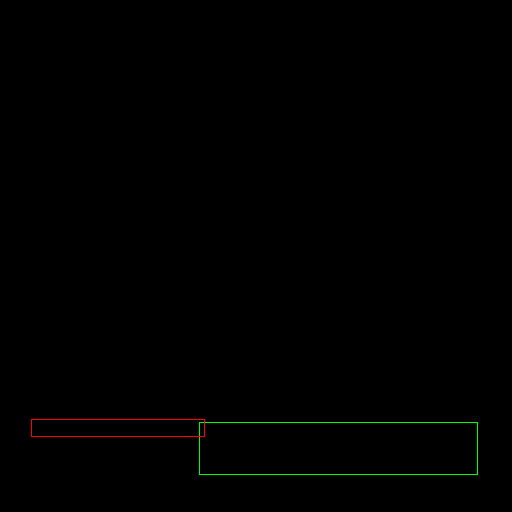

In [ ]:
# Visualize the boxes for one of the test cases
img = np.zeros([512,512,3] ,dtype = np.uint8)
box1, box2= iou_test_case_1[0], iou_test_case_1[1]
img2 = cv2.rectangle(img, (box1[0], box1[1]), (box1[2], box1[3]) , color = (0,255,0))#green
img2 = cv2.rectangle(img, (box2[0], box2[1]), (box2[2], box2[3]) , color = (0,0,255))#red

cv2_imshow(img2)

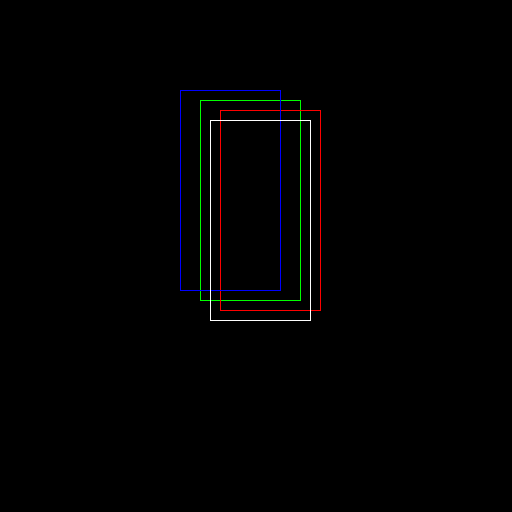

In [ ]:
# Visualize the boxes for one of the test cases
img = np.zeros([512,512,3] ,dtype = np.uint8)
box1, box2, box3, box4 = nms_test_case_1[0], nms_test_case_1[1], nms_test_case_1[2], nms_test_case_1[3]
img2 = cv2.rectangle(img, (box1[0], box1[1]), (box1[2], box1[3]) , color = (0,255,0))
img2 = cv2.rectangle(img, (box2[0], box2[1]), (box2[2], box2[3]) , color = (0,0,255))
img2 = cv2.rectangle(img, (box3[0], box3[1]), (box3[2], box3[3]) , color = (255,0,0))
img2 = cv2.rectangle(img, (box4[0], box4[1]), (box4[2], box4[3]) , color = (255,255,255)) 
cv2_imshow(img2)

In [ ]:
'''
Exercise: Implement iou(). Some hints:
    In this exercise only, we define a box using its two corners (lower left and
     upper right): (x1, y1, x2, y2) rather than the midpoint and height/width.
    To calculate the area of a rectangle you need to multiply its height 
    (y2 - y1) by its width (x2 - x1)
    You'll also need to find the coordinates (xi1, yi1, xi2, yi2) of the 
    intersection of two boxes. 
'''
def iou(box1, box2):
    """Implement the intersection over union (IoU) between box1 and box2
    Arguments:
    box1 -- first box, list object with coordinates (x1, y1, x2, y2)
    box2 -- second box, list object with coordinates (x1, y1, x2, y2)
    """
################################################################################
# TODO: Replace "None" with the correct code/ logic to find IoU for the boxes. #
# Remember to account for the case in which IoU is 0.                          #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    # Calculate the (y1, x1, y2, x2) coordinates of the intersection of box1   #
    # and box2. Calculate its Area.                                            #
    xi1 = max(box1[0],box2[0])
    yi1 = max(box1[1],box2[1])
    xi2 = min(box1[2],box2[2])
    yi2 = min(box1[3],box2[3])
    if((xi2-xi1)>0 and (yi2-yi1)>0):
        area=(xi2-xi1)*(yi2-yi1)
    else:
        area=0
    # Case in which they don't intersect --> max(,0)
    inter_area = area

    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    box1_area = (box1[2]-box1[0])*(box1[3]-box1[1])
    box2_area = (box2[2]-box2[0])*(box2[3]-box2[1])
    union_area = box1_area+box2_area-inter_area

    # compute the IoU
    iou =  inter_area/union_area
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    return iou

In [ ]:
################################################################################
# TODO: Replace "None" with the correct code/ logic to find IoU for the boxes. #
# Perform iou on the test cases                                                #
################################################################################
iou_result_1 = iou(iou_test_case_1[0], iou_test_case_1[1])
iou_result_2 = iou(iou_test_case_2[0], iou_test_case_2[1])
iou_result_3 = iou(iou_test_case_3[0], iou_test_case_3[1])
iou_result_4 = iou(iou_test_case_4[0], iou_test_case_4[1])
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

In [ ]:
# Print out the test cases:
print("IoU for 1st test case is: ", iou_result_1, 
      "IoU for 2nd test case is: ", iou_result_2, 
      "IoU for 3rd test case is: ", iou_result_3, 
      "IoU for 4th test case is: ", iou_result_4)

IoU for 1st test case is:  0.004039937669533099 IoU for 2nd test case is:  0.15201036013813518 IoU for 3rd test case is:  -0.0 IoU for 4th test case is:  0.07477937761263354


In [ ]:
'''
Exercise: Implement nms(). Some hints:
    In this functoin, we will be performing non max suppression to select 
    bounding boxes for an object.
    We will be assuming there is only one class of objects. However, the code is
    is not very different for multiple classes of objects. 
    
    c_score represents the confidence score of particular bounding box.

    Use the iou function defined earlier.

    Remember the algorithm to perform nms:
    Discard all bounding boxes with confidence score < c_score_threshold
    While there are any remaining boxes:
      Pick box with largest confidence, output that as prediction.
      Discard any remaining boxes with IoU > iou_threshold with the output box. 

    0.6 is an arbitrary number- feel free to experiment with it.

    Make use of list comprehenion
'''
def nms(bboxes,iou_threshold,c_score_threshold):
  '''
    Implement non max supression given a list of bounding boxes.
    Arguments:
    bboxes: list of lists- the inner lists contain 5 elements and are of the
            following format: [x1, y1, x2, y2, c_score]
    iou_threshold: The threshold above which bounding boxes with lower confidence
                    score are removed.
    c_score_threshold: The minimum value of c_score below which bounding boxes
                       are removed.
    ''' 
################################################################################
# TODO: Replace "None" with the correct code/ logic to find IoU for the boxes. #
# Remember to account for the case in which IoU is 0.                          #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

  #Using list comprehension (or otherwise), select bounding boxes which have
  # confidence score greater than c_score_threshold.
  bboxes = [x for x in bboxes if x[4]>=c_score_threshold]

  #Sort the bounding boxes in decresing order of confidence score.
  bboxes.sort(reverse=True)

  #An empty list to store selected bounding boxes.
  boxes_after_nms = []

  #Loop through the bounding boxes
  while bboxes:
      #Select box with highest confidence score
      chosen_box = bboxes[0]
      #Using list comprehension (or otherwise), eliminate bounding boxes whose
      #iou with "chosen_box" is greater than threshold.
      bboxes = [x for x in bboxes if iou(chosen_box,x)<=iou_threshold]
      #Add the bbox with highest confidence score to the formerly created list.
      boxes_after_nms.append(chosen_box)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
  return boxes_after_nms

In [ ]:
################################################################################
# TODO: Replace "None" with the correct code/ logic to find nms for the boxes. #
# Perform nms on the test cases 
# Experiment with values for iou threshold and c_score threshold               #
################################################################################
nms_result_1 = nms(nms_test_case_1,0.5,0.7)
nms_result_2 = nms(nms_test_case_2,0.5,0.7)
nms_result_3 = nms(nms_test_case_3,0.5,0.7)
nms_result_4 = nms(nms_test_case_4,0.5,0.7)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

In [ ]:
# Check the number of bounding boxes returned for eaach test case.
print("Number of bounding boxes returned for 1st test case is: ", len(nms_result_1), 
      "Number of bounding boxes returned for 2nd test case is: ", len(nms_result_2),
      "Number of bounding boxes returned for 3rd test case is: ", len(nms_result_3),
      "Number of bounding boxes returned for 4th test case is: ", len(nms_result_4))

Number of bounding boxes returned for 1st test case is:  2 Number of bounding boxes returned for 2nd test case is:  1 Number of bounding boxes returned for 3rd test case is:  2 Number of bounding boxes returned for 4th test case is:  2


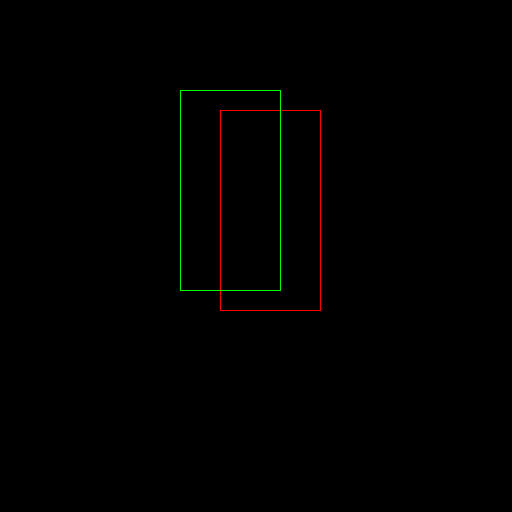

In [ ]:
# Depending on the number of bounding boxes, visualize the results. 
img = np.zeros([512,512,3] ,dtype = np.uint8)

box1 = nms_result_1[0]
img2 = cv2.rectangle(img, (box1[0], box1[1]), (box1[2], box1[3]) , color = (0,0,255))
box2=nms_result_1[1]
img2 = cv2.rectangle(img, (box2[0], box2[1]), (box2[2], box2[3]) , color = (0,255,0))
cv2_imshow(img)